In [2]:
from kinematics.kinematics import RoboticArm
import numpy as np

In [42]:
# Wszystkie wartości translacji w metrach
# Translacja T1 - pomiędzy J1, a J2
t1 = np.array([0.05, -0.035, 0, 1])

# Translacja T2 - pomiędzy J2, a J3
t2 = np.array([0.09, 0, 0, 1])

# Translacja T3 - pomiędzy J3, a FCP
t3 = np.array([0.1, 0, 0, 1])


a = RoboticArm(t1, t2, t3, 0, -np.pi/2)

In [128]:
class JointSpaceTrajectory:
    def __init__(self, kinematics_solver: RoboticArm):
        self._kinematics_solver = kinematics_solver
        
    def generate_trajectory(self, start_coordinates: np.ndarray, end_coordinates: np.ndarray, velocity_start: np.ndarray, velocity_end: np.ndarray, time_end: float):
        start_position = np.array([*start_coordinates, 1])
        end_position = np.array([*end_coordinates, 1])
        theta0_array = self._kinematics_solver.reverse(start_position)
        thetaf_array = self._kinematics_solver.reverse(end_position)
        
        print([x*180/np.pi for x in theta0_array])
        print([x*180/np.pi for x in thetaf_array])

        coefficients = []
        for i in range(3):
            coefficients.append(self.generate_polynomial_coefficients(theta0_array[i], thetaf_array[i], velocity_start[i], velocity_end[i], time_end))
            
        return coefficients
        
    def generate_polynomial_coefficients(self, theta_start, theta_end, velocity_start, velocity_end, time_end):
        A = np.array([[1, 0, 0, 0],
                      [1, time_end, pow(time_end, 2), pow(time_end, 3)],
                      [0, 1, 0, 0],
                      [0, 1, 2*time_end, 3*pow(time_end, 2)]]
                     )
        b = np.array([theta_start, theta_end, velocity_start, velocity_end])
        
        a = np.linalg.solve(A, b)
        return a

In [131]:
trajectory = JointSpaceTrajectory(a)
start_coordinates = np.array([-0.02, 0, 0])
end_coordinates = np.array([0.02, 0.05, 0.01])
velocity_start = np.array([0, 0, 0])
velocity_end = np.array([0, 0, 0])
time_end = 3

In [132]:
coefficients = trajectory.generate_trajectory(start_coordinates, end_coordinates, velocity_start, velocity_end, time_end)

[180.0, 280.6719292857622, -72.85379000110824]
[68.19859051364818, 226.67632744537778, -87.67363525042546]


In [133]:
coefficients

[array([ 3.14159265,  0.        , -0.65043423,  0.14454094]),
 array([ 4.89864928e+00, -1.48029737e-16, -3.14133678e-01,  6.98074840e-02]),
 array([-1.27153851,  0.        , -0.08621836,  0.01915964])]

In [134]:
import matplotlib.pyplot as plt

In [135]:
x = np.arange(0, time_end, 0.05)

In [136]:
x

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95])

In [148]:
j0_pos = np.poly1d(np.flip(coefficients[2]))
j0_vel = np.polyder(j0_pos)
j0_accel = np.polyder(j0_vel)

In [149]:
positions = j0_pos(x)
positions_deg = [angle*180/np.pi for angle in positions]

vels = j0_vel(x)

accels = j0_accel(x)

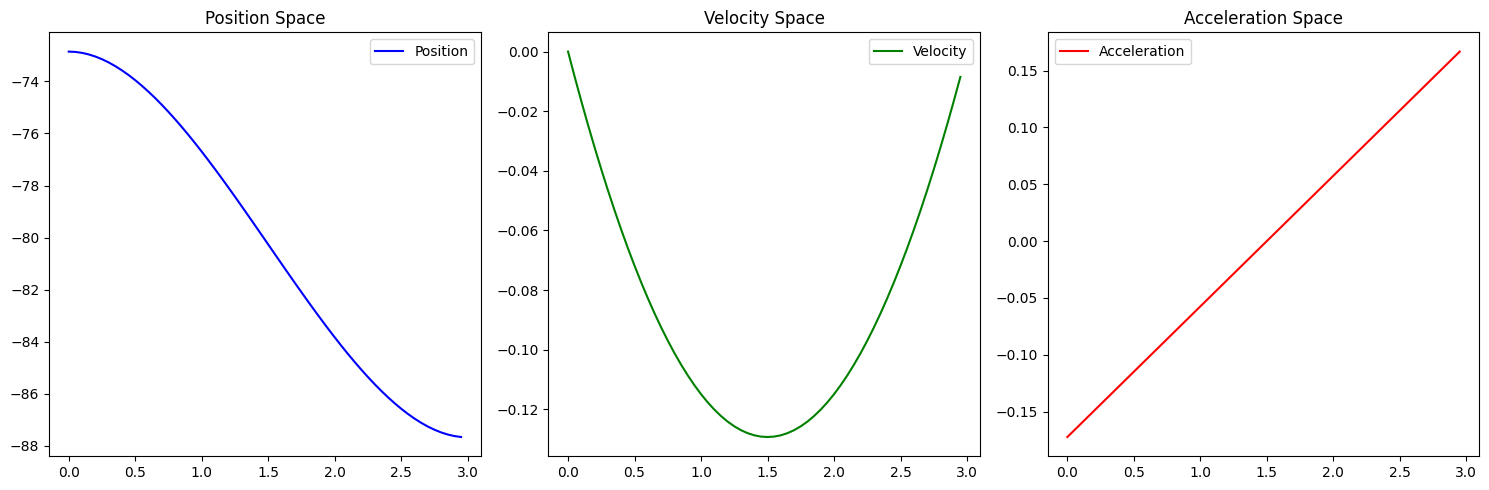

In [150]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot data on the first subplot
ax1.plot(x, positions_deg, label='Position', color='blue')
ax1.set_title('Position Space')
ax1.legend()

# Plot data on the second subplot
ax2.plot(x, vels, label='Velocity', color='green')
ax2.set_title('Velocity Space')
ax2.legend()

# Plot data on the third subplot
ax3.plot(x, accels, label='Acceleration', color='red')
ax3.set_title('Acceleration Space')
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()